# Potential Talents - An Apziva Project (#3)

# EDA

By Samuel Alter

Apziva: 6bImatZVlK6DnbEo

## Project Overview

#### Goals

#### The Dataset

## Imports and Helper Functions

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
from datetime import datetime
import json
from pathlib import Path
import inspect
import re
import string
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [144]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords # lists of stopwords
from nltk.tokenize import word_tokenize # tool for splitting documents into tokens
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer # basic stemmer
from nltk.stem import WordNetLemmatizer # more sophisticated word->lemma
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /Users/sra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [132]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [133]:
seed=rand_gen()
seed

7912

In [134]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x16524E9E0

In [135]:
def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

Read in the datset:

In [136]:
df=pd.read_csv('../data/3_data.csv')
df.head(3)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN


## Analysis

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


No nulls in the dataset. That is nice for us! There are 104 total observations.

In [138]:
df['fit'].value_counts()

Series([], Name: count, dtype: int64)

We'll remove `fit` as it is a column with no data.

In [139]:
if 'fit' in df.columns: # flow control for repeat code executions
    df.drop('fit',axis=1,inplace=True)

df.head()

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


Inspect the connections column:

In [140]:
connections=df['connection'].value_counts()

connections

connection
500+     44
85        7
61        7
44        6
1         5
2         4
4         2
7         2
57        2
390       2
103       1
48        1
18        1
71        1
19        1
415       1
9         1
64        1
39        1
155       1
349       1
174       1
40        1
50        1
268       1
455       1
52        1
409       1
212       1
16        1
5         1
82        1
49        1
Name: count, dtype: int64

I will change the "500+" into 500 so that it can remain a numeric value.

In [141]:
# remove all non-numeric characters from the column
if not pd.api.types.is_numeric_dtype(df['connection']):
    df['connection']=df['connection'].str.replace(r'\D','',regex=True)

    # check if any '+' characters are still present
    print("Amount of '+' in column:",df['connection'].str.contains(r'\+').sum())

    # convert to integer
    df['connection']=pd.to_numeric(df['connection'],errors='coerce')
    print(df.dtypes)

    # check if conversion was successful
    print('Was conversion successful?')
    if pd.api.types.is_numeric_dtype(df['connection']):
        print('Yes.')
    else:
        print('No.')

Amount of '+' in column: 0
id             int64
job_title     object
location      object
connection     int64
dtype: object
Was conversion successful?
Yes.


### Histogram of Connections

In [145]:
df_500fix=df.copy()
df_500fix['connection']=df['connection']\
.map(lambda x: 1000 if x>499 else x)

# check
df_500fix['connection'].value_counts().head(3)

connection
1000    44
85       7
61       7
Name: count, dtype: int64

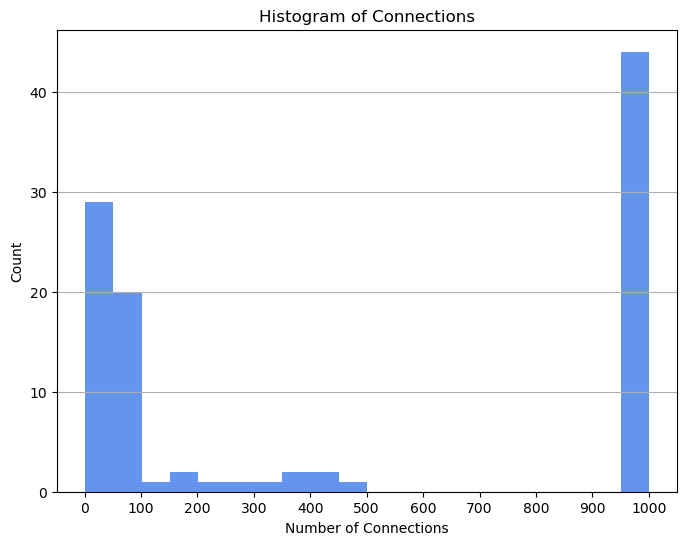

In [161]:
plt.figure(figsize=(8,6))
plt.hist(x=df_500fix['connection'],
         color='cornflowerblue',
         bins=20)
plt.title('Histogram of Connections\nNote: Those with greater than 500 connections are not shown')
plt.xlabel('Number of Connections')
plt.ylabel('Count')
plt.grid('minor',axis='y')
plt.xticks(range(0,1001,100)) # get xticks to appear every 100 connections

plt.savefig('figures/histogram_connections.pdf')
plt.savefig('figures/histogram_connections.jpg')
plt.savefig('figures/histogram_connections.png')

plt.show()

In [158]:
df[df['connection']<150]

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1
6,7,Student at Humber College and Aspiring Human R...,Kanada,61
8,9,Student at Humber College and Aspiring Human R...,Kanada,61
10,11,Student at Chapman University,"Lake Forest, California",2
13,14,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
14,15,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
16,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
18,19,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85


In [147]:
print(f"{df[df['connection']<150].sum()}")

id                                                         2744
job_title     2019 C.T. Bauer College of Business Graduate (...
location      Houston, TexasRaleigh-Durham, North Carolina A...
connection                                                 2100
dtype: object


Most observations have more than 500 connections.